In [1]:
import json
import gcsfs
# dir = C:\Users\annab\Desktop\ArgoEKE\github-argo-eke\data\
fp = r"C:\Users\annab\Desktop\ArgoEKE\pangeo-181919-e7bc5bdaf4d5.json" # dir+r'pangeo-181919-e7bc5bdaf4d5.json' #
with open(fp) as f:
    token = json.load(f)
gcs = gcsfs.GCSFileSystem(token=token) # file system instance
bucket_pth = 'pangeo-argo-eke/'

In [2]:
from mpl_params import *
import cmocean
plt.rcParams.update(mpl_params(font_family='serif'))

In [3]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
plt.rcParams['figure.dpi'] = 350
import xarray as xr
import numpy as np
import os
import datetime
import pandas as pd

# set the cwd to be the parent directory 
os.chdir(os.path.dirname(os.getcwd()))
print('Current working directory: ', os.getcwd())

Current working directory:  c:\Users\annab\Desktop\ArgoEKE


Open NOAA drifter-based climatology dataset

In [22]:
drifter_ds = xr.open_dataset(os.path.join(os.getcwd(), 'drifter_monthlymeans.nc'), decode_times=False)
    # gcs.get_mapper('pangeo-argo-eke/climatology/drifter/drifter_monthlymeans.nc'))
drifter_ds

<xarray.Dataset> Size: 532MB
Dimensions:  (latitude: 632, longitude: 1440, time: 12)
Coordinates:
    Lat      (latitude) float64 5kB ...
    Lon      (longitude) float64 12kB ...
    Time     (time) float64 96B ...
Dimensions without coordinates: latitude, longitude, time
Data variables:
    U        (time, longitude, latitude) float64 87MB ...
    V        (time, longitude, latitude) float64 87MB ...
    SST      (time, longitude, latitude) float64 87MB ...
    eU       (time, longitude, latitude) float64 87MB ...
    eV       (time, longitude, latitude) float64 87MB ...
    eSST     (time, longitude, latitude) float64 87MB ...
    N        (longitude, latitude) float64 7MB ...
Attributes:
    title:        drifter_monthlymeans
    description:  Monthly Means of Drifter Data
    version:      3.10
    date2:        File created 21-Aug-2023 09:38:21
    datadate:     Climatology uses data through 28-Feb-2023
    institution:  NOAA/AOML & Univ. Miami
    author:       Laurindo, Mariano, and Lumpkin (2017), Deep-Sea Res. I, doi...

Open Argo float-based geostrophic velocity (climatology) dataset

In [5]:
plevel=2
argo_ds_10dbar = xr.open_zarr(gcs.get_mapper( 'pangeo-argo-eke/climatology/version_1/plevel'+str(plevel)+'.zarr'), consolidated=True).compute()  # load the dataset
argo_ds_10dbar

<xarray.Dataset> Size: 398MB
Dimensions:    (latitude: 720, longitude: 1440, month: 12, pressure: 1)
Coordinates:
  * latitude   (latitude) float64 6kB -90.0 -89.75 -89.5 ... 89.25 89.5 89.75
  * longitude  (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * pressure   (pressure) float64 8B 10.0
Data variables:
    u          (latitude, longitude, month, pressure) float64 100MB nan ... nan
    umse       (latitude, longitude, month, pressure) float64 100MB nan ... nan
    v          (latitude, longitude, month, pressure) float64 100MB nan ... nan
    vmse       (latitude, longitude, month, pressure) float64 100MB nan ... nan
Attributes:
    created_date:     2025-02-02 11:03:56.003185
    description:      Absolute geostrophic velocity estimate monthly climatol...
    largescale_file:  pangeo-argo-eke/testfolder_112/vel_largescale_monthly_g...
    method:           DataArray.groupby("time.month").mean()
    smallscale_file:  pangeo-argo-eke/testfolder_127/vel_smallscale_monthly_g...

In [6]:
plevel=3
argo_ds_20dbar = xr.open_zarr(gcs.get_mapper( 'pangeo-argo-eke/climatology/version_1/plevel'+str(plevel)+'.zarr'), consolidated=True).compute()
# argo_ds_20dbar

### Match the spatial locations of the two datasets

Data processing: Drifter data is 0.125 degrees shifted and has a reduced latitude range, Argo data is at 10 and 20 dbar levels

In [23]:
# rename the drifter Lat and Lon variables to be latitude and longitude
drifter_ds = drifter_ds.rename({'time':'month', 'Lat':'latitude', 'Lon':'longitude', "Time":"month"})
drifter_ds['month'] = (drifter_ds['month'] + 1).astype('int64') 
# mask out the latitudes in the Argo dataset that are not in the drifter dataset
max_drifter_lat = drifter_ds.latitude.max().values
min_drifter_lat = drifter_ds.latitude.min().values
print('Max drifter latitude: ', max_drifter_lat)
print('Min drifter latitude: ', min_drifter_lat)

Max drifter latitude:  84.875
Min drifter latitude:  -72.875


C:\Users\annab\AppData\Local\Temp\ipykernel_10764\2806230106.py:2: UserWarning: rename 'Lat' to 'latitude' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  drifter_ds = drifter_ds.rename({'time':'month', 'Lat':'latitude', 'Lon':'longitude', "Time":"month"})
C:\Users\annab\AppData\Local\Temp\ipykernel_10764\2806230106.py:2: UserWarning: rename 'Lon' to 'longitude' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  drifter_ds = drifter_ds.rename({'time':'month', 'Lat':'latitude', 'Lon':'longitude', "Time":"month"})


In [24]:
argo_ds_10dbar = argo_ds_10dbar.where((argo_ds_10dbar.latitude <= max_drifter_lat) & (argo_ds_10dbar.latitude >= min_drifter_lat), drop=True)
argo_ds_20dbar = argo_ds_20dbar.where((argo_ds_20dbar.latitude <= max_drifter_lat) & (argo_ds_20dbar.latitude >= min_drifter_lat), drop=True)

print('Drifter dataset: ', drifter_ds)
print('Argo dataset at 10 dbar: ', argo_ds_10dbar)

Drifter dataset:  <xarray.Dataset> Size: 532MB
Dimensions:    (latitude: 632, longitude: 1440, month: 12)
Coordinates:
    latitude   (latitude) float64 5kB -72.88 -72.62 -72.38 ... 84.38 84.62 84.88
    longitude  (longitude) float64 12kB ...
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    U          (month, longitude, latitude) float64 87MB ...
    V          (month, longitude, latitude) float64 87MB ...
    SST        (month, longitude, latitude) float64 87MB ...
    eU         (month, longitude, latitude) float64 87MB ...
    eV         (month, longitude, latitude) float64 87MB ...
    eSST       (month, longitude, latitude) float64 87MB ...
    N          (longitude, latitude) float64 7MB ...
Attributes:
    title:        drifter_monthlymeans
    description:  Monthly Means of Drifter Data
    version:      3.10
    date2:        File created 21-Aug-2023 09:38:21
    datadate:     Climatology uses data through 28-Feb-2023
    institution:  NOAA/AOML

In [25]:
# replace the point at longitude == -180 with longitude == 180 in drifter dataset
print('Drifter dataset longitude range before adjustment: ', drifter_ds.longitude.min().values, drifter_ds.longitude.max().values)
drifter_ds['longitude'] = drifter_ds['longitude'].where(drifter_ds['longitude'] != 180, -180)
drifter_ds = drifter_ds.sortby('longitude')
print('Drifter dataset longitude range after adjustment: ', drifter_ds.longitude.min().values, drifter_ds.longitude.max().values)

print('Argo dataset at 10 dbar longitude range: ', argo_ds_10dbar.longitude.min().values, argo_ds_10dbar.longitude.max().values)

Drifter dataset longitude range before adjustment:  -179.875 179.875
Drifter dataset longitude range after adjustment:  -179.875 179.875
Argo dataset at 10 dbar longitude range:  -180.0 179.75


In [26]:
# take the mean of the Argo dataset at 10 dbar and 20 dbar
argo_ds_15dbar_u = (argo_ds_10dbar.u.values + argo_ds_20dbar.u.values) / 2
argo_ds_15dbar_v = (argo_ds_10dbar.v.values + argo_ds_20dbar.v.values) / 2
argo_ds_15dbar_u = argo_ds_15dbar_u.squeeze().T
argo_ds_15dbar_v = argo_ds_15dbar_v.squeeze().T
drifter_ds_u = drifter_ds.U.values; drifter_ds_v = drifter_ds.V.values
print(argo_ds_15dbar_u)
print(drifter_ds_u)


[[[        nan         nan -0.00577108 ...         nan         nan
           nan]
  [        nan         nan -0.00576998 ...         nan         nan
           nan]
  [        nan         nan -0.00581325 ...         nan         nan
           nan]
  ...
  [        nan         nan -0.00385997 ...         nan         nan
           nan]
  [        nan         nan -0.00385221 ...         nan         nan
           nan]
  [        nan         nan -0.00577163 ...         nan         nan
           nan]]

 [[        nan         nan -0.0045142  ...         nan         nan
           nan]
  [        nan         nan -0.00449463 ...         nan         nan
           nan]
  [        nan         nan -0.0045183  ...         nan         nan
           nan]
  ...
  [        nan         nan -0.00313248 ...         nan         nan
           nan]
  [        nan         nan -0.00311405 ...         nan         nan
           nan]
  [        nan         nan -0.0045362  ...         nan         nan
      

In [ ]:
from mpl_params import *
import cmocean
plt.rcParams.update(mpl_params(font_family='serif'))

In [17]:
def plot_histogram_comparison(arr1, arr2, label1='Argo', label2='Drifter', bins=40, title='Histogram Comparison', xlabel='Velocity (m/s)', ylabel='Frequency', month=1):
    arr1_month = arr1[month-1, :, :].flatten()
    arr2_month = arr2[month-1, :, :].flatten()
    plt.figure(figsize=(10, 6))
    plt.hist(arr1_month, bins=bins, alpha=0.5, label=label1, color='blue', density=True)
    plt.hist(arr2_month, bins=bins, alpha=0.5, label=label2, color='orange', density=True)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.show()

Interpolate the Argo data to the drifter locations using bilinear interpolation

In [72]:
from scipy.interpolate import RegularGridInterpolator

# interpolate the Argo dataset to the drifter grid
def interpolate_argo_to_drifter(argo_values, argo_lats, argo_lons, drifter_ds):
    # print('argo lats shape: ', argo_lats.shape); print('argo lons shape: ', argo_lons.shape); print('argo values shape: ', argo_values.shape)
    # LONS, LATS = np.meshgrid(argo_lons, argo_lats, indexing='ij') 
    # # check if lons are strictly increasing
    # print(np.where(np.diff(LONS) < 0))  # should be empty if lons are strictly increasing CHECKED, YIELDS EMPTY ARRAYS
    # print(np.where(np.diff(LATS) < 0))  # should be empty if lats are strictly increasing, CHEKCED, YIELDS EMPTY ARRAYS
    # print(points_list[0].shape, points_list[1].shape)
    # points_tuple = list(zip(*[arr.flatten() for arr in points_list]))  # Flatten the meshgrid arrays and combine them into a list of tuples
    # print(points_tuple[:5])  # Print first 5 points for debugging
    # print(points_tuple[-5:])  # Print last 5 points for debugging
    interpolator = RegularGridInterpolator(
        (argo_lons, argo_lats),
        argo_values,
        method='linear',
        bounds_error=False,  # if True, will raise an error for points outside the grid
    )
    drifter_lons = drifter_ds.longitude.values  # (1440,)
    drifter_lats = drifter_ds.latitude.values   # (632,)

    # Make a 2D grid
    LON_GRID, LAT_GRID = np.meshgrid(drifter_lons, drifter_lats, indexing='ij')  # both shape (1440, 632)

    # Stack into (N, 2) points for interpolation
    points = np.column_stack((LON_GRID.ravel(), LAT_GRID.ravel()))  # shape (1440*632, 2)
    # points = np.array(list(zip(drifter_ds.longitude.values, drifter_ds.latitude.values)))
    
    interpolated_values = interpolator(points)
    # print('Interpolated values shape: ', interpolated_values.shape)  # should be (1440*632,)
    
    return interpolated_values

In [ ]:
argo_lats = argo_ds_10dbar.latitude.values; argo_lons = argo_ds_10dbar.longitude.values
intrp_argo_u = np.empty((12, len(drifter_ds.longitude), len(drifter_ds.latitude)))
intrp_argo_v = np.empty((12, len(drifter_ds.longitude), len(drifter_ds.latitude)))
for month_ind in range(12):
    month=month_ind + 1
    if month_ind==0: print(f'pre interpolation argo u month {month} first 5 vals: ', argo_ds_15dbar_u[month-1, :5,:5])
    if month_ind==0: print(f'pre interpolation argo v month {month} first 5 vals: ', argo_ds_15dbar_v[month-1, :5,:5])
    intrp_argo_to_drifter_u = interpolate_argo_to_drifter(argo_ds_15dbar_u[month_ind,:,:], argo_lats, argo_lons, drifter_ds).reshape(len(drifter_ds.longitude), len(drifter_ds.latitude))
    intrp_argo_to_drifter_v = interpolate_argo_to_drifter(argo_ds_15dbar_v[month_ind,:,:], argo_lats, argo_lons, drifter_ds).reshape(len(drifter_ds.longitude), len(drifter_ds.latitude))
    if month_ind==0: print('intrp_argo_to_drifter_u.shape, intrp_argo_to_drifter_v.shape', intrp_argo_to_drifter_u.shape, intrp_argo_to_drifter_v.shape)
    intrp_argo_u[month_ind, :, :] = intrp_argo_to_drifter_u
    intrp_argo_v[month_ind, :, :] = intrp_argo_to_drifter_v
    if month_ind==0: print('intrp_argo_to_drifter_u first 5 values: ', intrp_argo_to_drifter_u[:5,:5])
    if month_ind==0: print('intrp_argo_to_drifter_v first 5 values: ', intrp_argo_to_drifter_v[:5,:5])

pre interpolation argo u month 1 first 5 vals:  [[        nan         nan -0.00577108 -0.00580684 -0.00493165]
 [        nan         nan -0.00576998 -0.00581734 -0.00550224]
 [        nan         nan -0.00581325 -0.00582328 -0.00607143]
 [        nan         nan -0.00837021 -0.00839318 -0.00666913]
 [        nan         nan -0.00836521 -0.00839829 -0.00723232]]
pre interpolation argo v month 1 first 5 vals:  [[        nan         nan -0.00419084 -0.00416846 -0.00300362]
 [        nan         nan -0.00416025 -0.00413624 -0.00251179]
 [        nan         nan -0.00415411 -0.00410478 -0.00201949]
 [        nan         nan -0.00216494 -0.00211214 -0.00152399]
 [        nan         nan -0.0021399  -0.00208735 -0.00103462]]
(1440, 632) (1440, 632)
intrp_argo_to_drifter_u first 5 values:  [[        nan         nan         nan -0.00579131 -0.00551452]
 [        nan         nan         nan -0.00580596 -0.00580357]
 [        nan         nan         nan -0.00709998 -0.00673926]
 [        nan     

In [ ]:
intrp_argo_drifter_u_diff = intrp_argo_u - drifter_ds_u
intrp_argo_drifter_v_diff = intrp_argo_v - drifter_ds_v
def plot_1d_diff_field(diff_arr, latitudes, longitudes, title, cmap=cmocean.cm.balance, vmin=None, vmax=None, month=1, lognorm=None):
    ax = map_params(figsize=(10,6))
    ax.set_title(title, fontsize=12)

    print(longitudes.shape, latitudes.shape, diff_arr[month-1,:,:].shape)
    mesh = ax.pcolormesh(longitudes, latitudes, diff_arr[month-1,:,:].T,
                         cmap=cmap,
                         transform=ccrs.PlateCarree(),
                         vmin=vmin, vmax=vmax,
                        #  norm=lognorm,
                         shading='auto')  # 'auto' recommended to avoid warning

    extend = 'both' if vmin is not None and vmax is not None else 'neither'
    plt.colorbar(mesh, ax=ax, orientation='horizontal', label='Velocity Difference at 15 dbar (m/s)', extend=extend)
    plt.show()

latitudes = drifter_ds.latitude.values
longitudes = drifter_ds.longitude.values


### Comparison visualiations

Density/Histogram plots of the two datasets

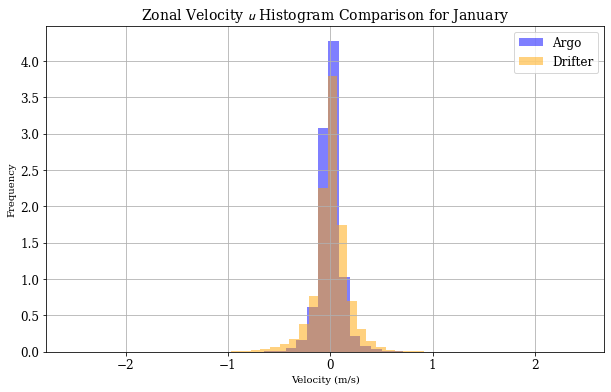

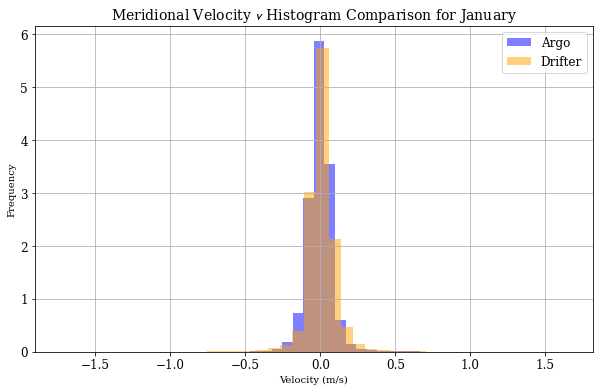

In [84]:
plot_histogram_comparison(intrp_argo_drifter_u_diff, drifter_ds_u, title='Zonal Velocity $u$ Histogram Comparison for January')
plot_histogram_comparison(intrp_argo_drifter_v_diff, drifter_ds_v, title='Meridional Velocity $v$ Histogram Comparison for January')

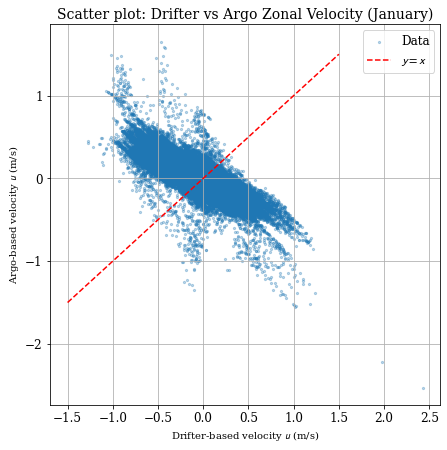

In [83]:
# Flatten arrays for January (month=1)
drifter_u_flat = drifter_ds_u[0, :, :].flatten()
argo_u_flat = intrp_argo_drifter_u_diff[0, :, :].flatten()

# Remove NaNs from both arrays
mask = ~np.isnan(drifter_u_flat) & ~np.isnan(argo_u_flat)
drifter_u_clean = drifter_u_flat[mask]
argo_u_clean = argo_u_flat[mask]

plt.figure(figsize=(7, 7))
plt.scatter(drifter_u_clean, argo_u_clean, alpha=0.3, s=5, label='Data')
min_val = -1.5 #min(drifter_u_clean.min(), argo_u_clean.min())
max_val = 1.5 #max(drifter_u_clean.max(), argo_u_clean.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='$y=x$')
plt.xlabel('Drifter-based velocity $u$ (m/s)')
plt.ylabel('Argo-based velocity $u$ (m/s)')
plt.title('Scatter plot: Drifter vs Argo Zonal Velocity (January)')
plt.legend()
plt.grid(True)
plt.show()

(1440,) (632,) (1440, 632)


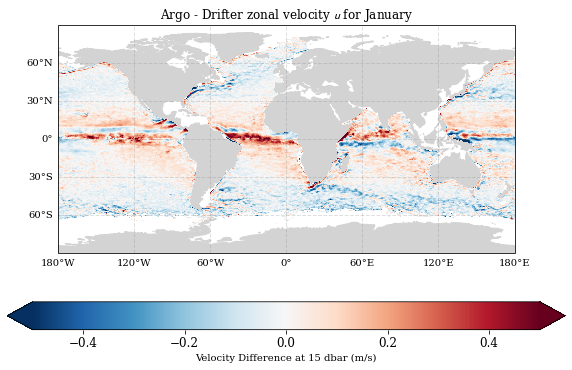

(1440,) (632,) (1440, 632)


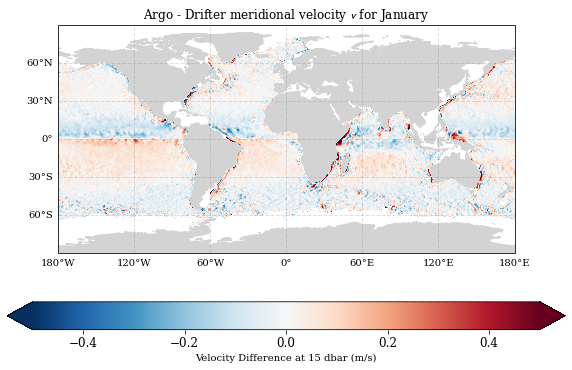

(1440,) (632,) (1440, 632)


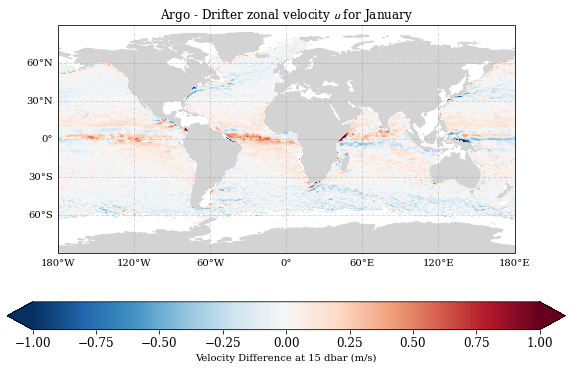

(1440,) (632,) (1440, 632)


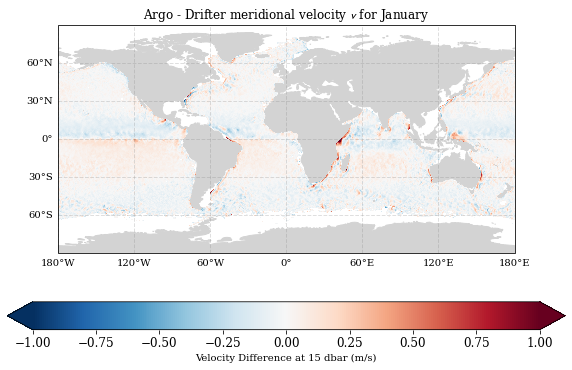

In [79]:
# from matplotlib.colors import LogNorm
plot_1d_diff_field(intrp_argo_drifter_u_diff, latitudes, longitudes, f'Argo - Drifter zonal velocity $u$ for January', cmap='RdBu_r', vmin=-0.5, vmax=.5)
plot_1d_diff_field(intrp_argo_drifter_v_diff, latitudes, longitudes, f'Argo - Drifter meridional velocity $v$ for January', cmap='RdBu_r', vmin=-.5, vmax=.5)
plot_1d_diff_field(intrp_argo_drifter_u_diff, latitudes, longitudes, f'Argo - Drifter zonal velocity $u$ for January', cmap='RdBu_r', vmin=-1, vmax=1)
plot_1d_diff_field(intrp_argo_drifter_v_diff, latitudes, longitudes, f'Argo - Drifter meridional velocity $v$ for January', cmap='RdBu_r', vmin=-1, vmax=1)
# plot_1d_diff_field(argo_drifter_u_diff, latitudes, longitudes, f'Argo - Drifter zonal velocity $u$', cmap='RdBu_r', vmin=None, vmax=None)
# plot_1d_diff_field(argo_drifter_v_diff, latitudes, longitudes, f'Argo - Drifter meridional velocity $v$', cmap='RdBu_r', vmin=None, vmax=None)
# plot_1d_diff_field(argo_drifter_u_diff, latitudes, longitudes, f'Argo - Drifter zonal velocity $u$', cmap='RdBu_r', lognorm=LogNorm()) #vmin=-2, vmax=2
# plot_1d_diff_field(argo_drifter_v_diff, latitudes, longitudes, f'Argo - Drifter meridional velocity $v$', cmap='RdBu_r', lognorm=LogNorm()) #vmin=-1.5, vmax=1.5


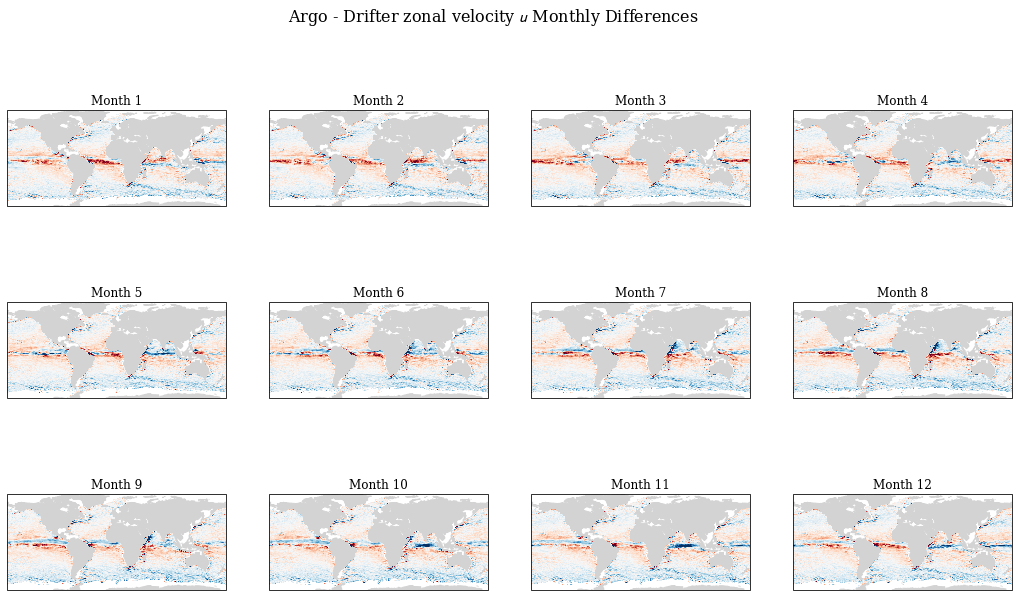

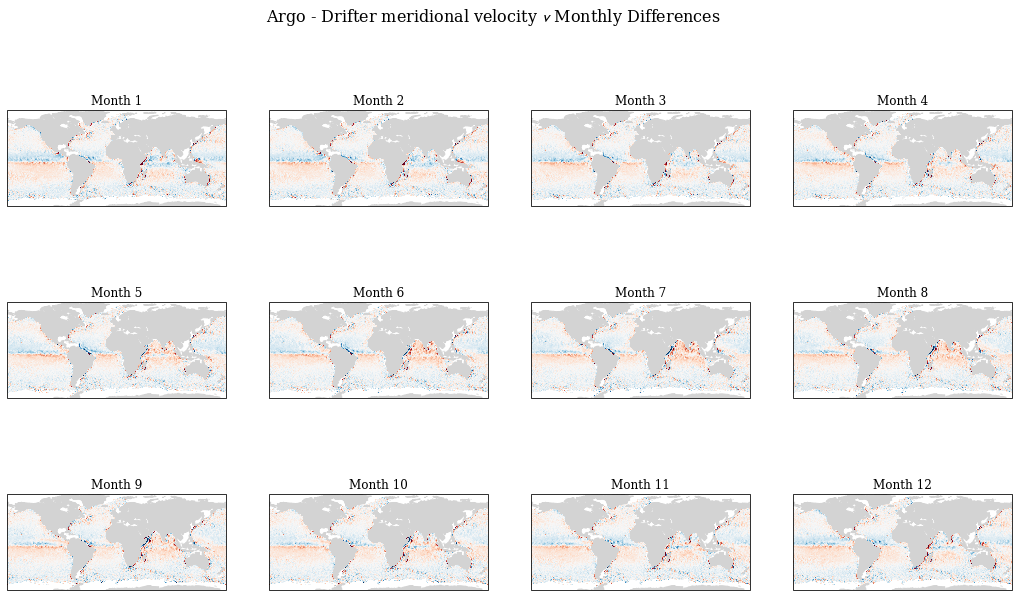

In [81]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='cartopy')
def plot_1d_diff_field_monthly(diff_arr, latitudes, longitudes, title, cmap=cmocean.cm.balance, vmin=None, vmax=None, lognorm=None):
    fig, axs = plt.subplots(3, 4, figsize=(18, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    fig.suptitle(title, fontsize=16)
    
    for month in range(1, 13):
        ax = axs[(month-1)//4, (month-1)%4]
        ax.set_title(f'Month {month}', fontsize=12)
        
        mesh = ax.pcolormesh(longitudes, latitudes, diff_arr[month-1,:,:].T,
                             cmap=cmap,
                             transform=ccrs.PlateCarree(),
                             vmin=vmin, vmax=vmax,
                            #  norm=lognorm,
                             shading='auto')  # 'auto' recommended to avoid warning
        
        # extend = 'both' if vmin is not None and vmax is not None else 'neither'
        # plt.colorbar(mesh, ax=ax, orientation='horizontal', label='Velocity Difference at 15 dbar (m/s)', extend=extend)
        
        land = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face', facecolor='lightgray')
        ax.add_feature(land, zorder=0)

    # plt.tight_layout()
    plt.show()
plot_1d_diff_field_monthly(intrp_argo_drifter_u_diff, latitudes, longitudes, f'Argo - Drifter zonal velocity $u$ Monthly Differences', cmap='RdBu_r', vmin=-0.5, vmax=0.5)
plot_1d_diff_field_monthly(intrp_argo_drifter_v_diff, latitudes, longitudes, f'Argo - Drifter meridional velocity $v$ Monthly Differences', cmap='RdBu_r', vmin=-0.5, vmax=0.5)